In [1]:
import math
import time
import calendar
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
river_df = pd.read_csv('riverlevel.csv')

# convert month name to integer
month_dict = dict((v, k) for k, v in enumerate(calendar.month_name))
river_df['Month'] = river_df['Month'].map(month_dict)

# create datetime column
river_df[['Year', 'Month', 'Day', 'Hour']] = river_df[['Year', 'Month', 'Day', 'Hour']].astype(int)
river_df['Hour'] = river_df['Hour'].apply(lambda x: x if x < 24 else 0)
river_df['Datetime'] = river_df[['Year', 'Month', 'Day', 'Hour']].apply(lambda row: datetime(row['Year'], row['Month'], row['Day'], row['Hour']).isoformat(), axis=1)
river_df["Datetime"] = pd.to_datetime(river_df["Datetime"], format='ISO8601')

# make datetime as index
river_df.index = river_df["Datetime"]
river_df = river_df.drop(['Datetime'], axis=1)

# remove non numeric fields
river_df = river_df[['Waterlevel', 'Waterlevel.1', 'Waterlevel.2', 'RF-Intensity', 'RF-Intensity.1', 'Precipitation', 'Humidity', 'Temperature']]
river_df = river_df.astype(np.float64)

# resolve missing values
river_df = river_df.interpolate(method='linear', limit_direction='forward')
river_df = river_df.resample('24H').max()

river_df

,Waterlevel,Waterlevel.1,Waterlevel.2,RF-Intensity,RF-Intensity.1,Precipitation,Humidity,Temperature
Datetime,,,,,,,,
2012-01-01,15.94,12.53,21.97,0.0,0.0,0.08,18.01,28.69
2012-01-02,15.86,12.52,21.96,0.0,4.0,0.41,17.88,28.08
2012-01-03,15.94,12.51,21.94,7.0,4.0,1.64,17.88,27.39
2012-01-04,16.00,12.50,22.03,0.0,0.0,1.41,17.82,27.20
2012-01-05,15.85,12.49,22.01,0.0,0.0,0.35,16.36,26.10
...,...,...,...,...,...,...,...,...
2022-12-27,15.87,12.22,21.30,0.0,0.0,0.46,14.71,23.97
2022-12-28,15.87,12.19,21.30,0.0,1.0,2.95,15.81,25.87
2022-12-29,15.87,12.17,21.30,0.0,1.0,1.29,18.43,25.80


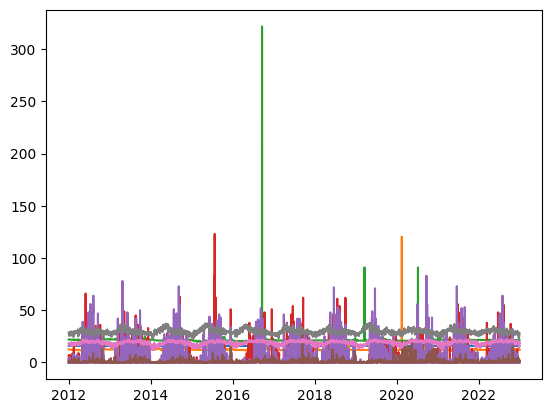

In [3]:
plt.plot(river_df)
plt.show()

(3989, 8)
Waterlevel


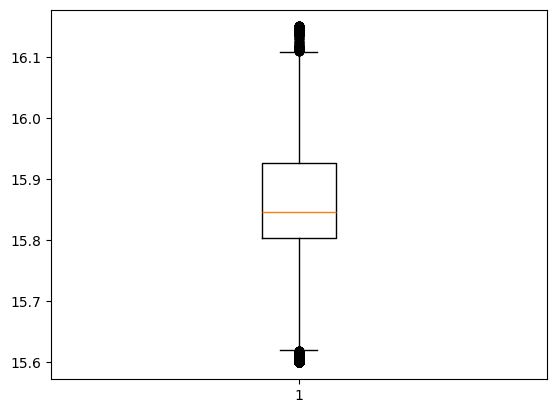

Waterlevel.1


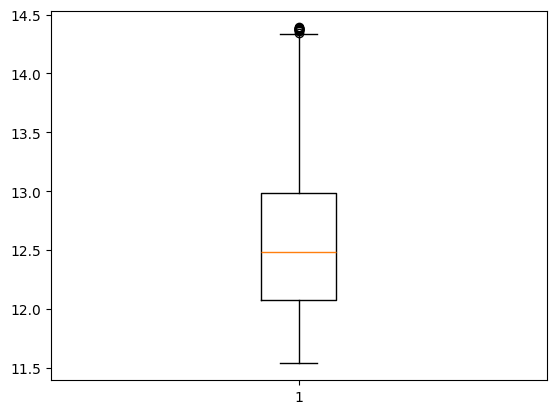

Waterlevel.2


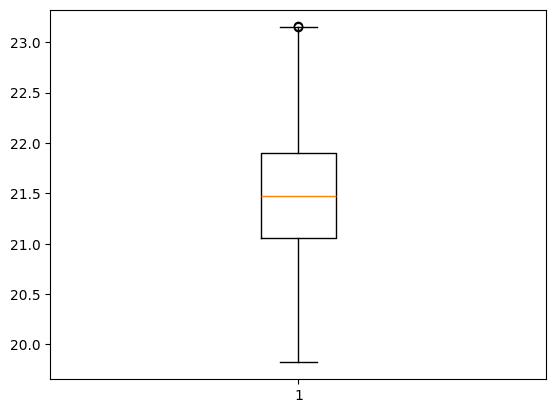

RF-Intensity


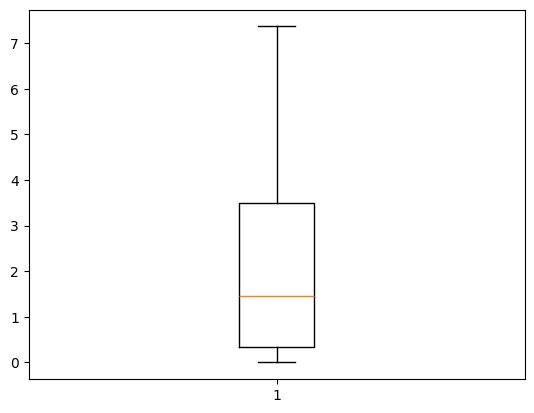

RF-Intensity.1


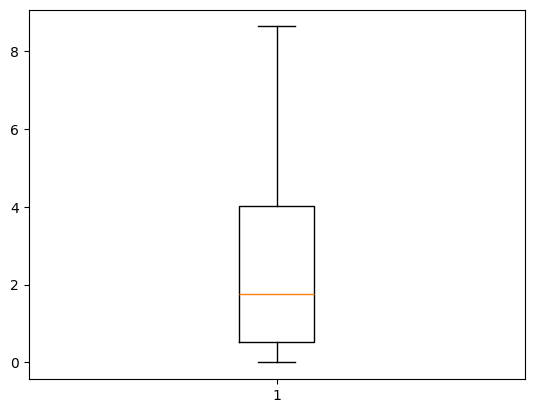

Precipitation


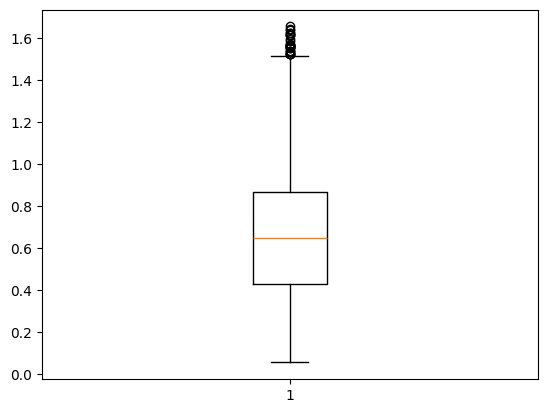

Humidity


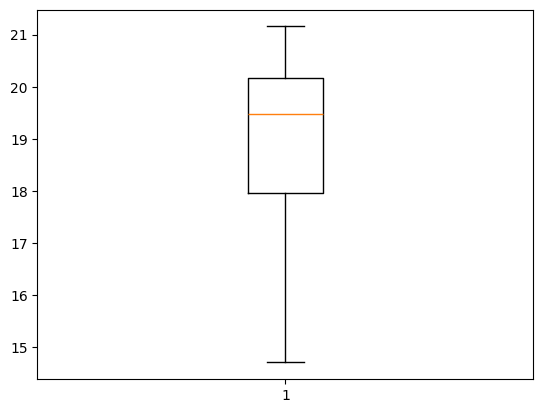

Temperature


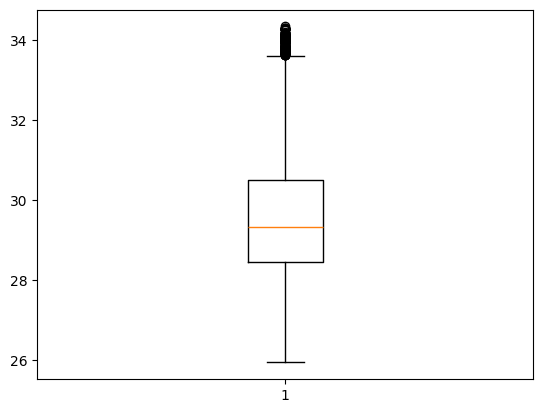

In [4]:
# remove outliers
river_df['Waterlevel'] = river_df['Waterlevel'].clip(upper=16.15, lower=15.60)
river_df['Waterlevel.1'] = river_df['Waterlevel.1'].clip(upper=14.50, lower=10.00)
river_df['Waterlevel.2'] = river_df['Waterlevel.2'].clip(upper=23.20, lower=15.00)
river_df['RF-Intensity'] = river_df['RF-Intensity'].clip(upper=11.00, lower=0.00)
river_df['RF-Intensity.1'] = river_df['RF-Intensity.1'].clip(upper=11.00, lower=0.00)
river_df['Precipitation'] = river_df['Precipitation'].clip(upper=2.00, lower=0.00)
river_df['Humidity'] = river_df['Humidity'].clip(upper=50.00, lower=12.00)
river_df['Temperature'] = river_df['Temperature'].clip(upper=34.50, lower=23.50)

# smoothen again to prevent stagnant values
river_df = river_df.rolling(30).mean().dropna()
print(river_df.values.shape)

for col in river_df.columns:
    print(col)
    plt.boxplot(river_df[col])
    plt.show()

In [5]:
train_df = river_df['2015-01-01': '2023-01-01']
test_df = river_df['2012-01-01': '2015-01-01']

print(train_df.shape)
print(test_df.shape)

(2922, 8)
(1068, 8)


In [6]:
SEQ_LEN = 730
LABEL_LEN = 365 
PRED_LEN = 365
OUTPUT_ATTENTION = False
MOVING_AVERAGE = 125
ENC_IN = 8 
DEC_IN = 8
C_OUT = 8 
D_MODEL = 16 
D_FF = 2048
FREQ = 'h' 
N_HEADS = 4 
ENC_LAYERS = 2
DEC_LAYERS = 1
BATCH_SIZE = 64

In [7]:
# Define dataset
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, df, seq_len, label_len, pred_len):
        self.df = df
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = pred_len
        
        # get the time encoding
        stamp_df = pd.DataFrame({
            'month': self.df.index.month,
            'day': self.df.index.day,
            'weekday': self.df.index.weekday,
            'hour': self.df.index.hour
        })
        data_stamp = stamp_df.values
        data_stamp = np.vstack((data_stamp, data_stamp))
        
        # train scaler
        self.scaler = MinMaxScaler()
        self.scaler.fit(self.df)
        
        # scale data
        scaled_data = self.scaler.transform(self.df)
        scaled_data = np.vstack((scaled_data, scaled_data))
        
        self.data_x = scaled_data
        self.data_y = scaled_data
        self.data_stamp = data_stamp
        
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        
        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1
    
    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [8]:
train_dataset = TimeSeriesDataset(
    df=train_df,
    seq_len=SEQ_LEN,
    label_len=LABEL_LEN,
    pred_len=PRED_LEN
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

test_dataset = TimeSeriesDataset(
    df=test_df,
    seq_len=SEQ_LEN,
    label_len=LABEL_LEN,
    pred_len=PRED_LEN
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

In [9]:
print(len(train_data_loader))
print(len(test_data_loader))

75
17


In [10]:
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1).float()).transpose(1, 2)
        return x

class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        self.hour_embed = FixedEmbedding(hour_size, d_model)
        self.weekday_embed = FixedEmbedding(weekday_size, d_model)
        self.day_embed = FixedEmbedding(day_size, d_model)
        self.month_embed = FixedEmbedding(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x

class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()
        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x)

In [11]:
class AutoCorrelation(nn.Module):
    def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def time_delay_agg_training(self, values, corr):
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
        weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(index[i]), -1)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_inference(self, values, corr):
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        weights, delay = torch.topk(mean_value, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_full(self, values, corr):
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        weights, delay = torch.topk(corr, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[..., i].unsqueeze(-1)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * (tmp_corr[..., i].unsqueeze(-1))
        return delays_agg

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values = values[:, :L, :, :]
            keys = keys[:, :L, :, :]

        # period-based dependencies
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, n=L, dim=-1)

        # time delay agg
        if self.training:
            V = self.time_delay_agg_training(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)
        else:
            V = self.time_delay_agg_inference(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)

        if self.output_attention:
            return (V.contiguous(), corr.permute(0, 3, 1, 2))
        else:
            return (V.contiguous(), None)


class AutoCorrelationLayer(nn.Module):
    def __init__(self, correlation, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AutoCorrelationLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_correlation = correlation
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_correlation(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

In [12]:
class AutoLayerNorm(nn.Module):
    def __init__(self, channels):
        super(AutoLayerNorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels)

    def forward(self, x):
        x_hat = self.layernorm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias


class MovingAvg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(MovingAvg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super(SeriesDecomposition, self).__init__()
        self.moving_avg = MovingAvg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, moving_avg=25, dropout=0.1):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = SeriesDecomposition(moving_avg)
        self.decomp2 = SeriesDecomposition(moving_avg)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(x, x, x, attn_mask=attn_mask)
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(F.gelu(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, c_out, d_ff=None, moving_avg=25, dropout=0.1):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = SeriesDecomposition(moving_avg)
        self.decomp2 = SeriesDecomposition(moving_avg)
        self.decomp3 = SeriesDecomposition(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=3, stride=1, padding=1, padding_mode='circular', bias=False)

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x, trend1 = self.decomp1(x)
        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])
        x, trend2 = self.decomp2(x)
        y = x
        y = self.dropout(F.gelu(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        x, trend3 = self.decomp3(x + y)

        residual_trend = trend1 + trend2 + trend3
        residual_trend = self.projection(residual_trend.permute(0, 2, 1)).transpose(1, 2)
        return x, residual_trend


class Decoder(nn.Module):
    """
    Autoformer decoder
    """
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, trend=None):
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)
            trend = trend + residual_trend

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x, trend

In [13]:
class Autoformer(nn.Module):
    def __init__(self, seq_len, label_len, pred_len, output_attention, moving_avg, enc_in, dec_in, c_out, d_model, d_ff, freq, n_heads, e_layers, d_layers):
        super(Autoformer, self).__init__()
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = pred_len
        self.output_attention = output_attention

        # Decomposition
        kernel_size = moving_avg
        self.decomp = SeriesDecomposition(kernel_size)

        # Embedding
        # The series-wise connection inherently contains the sequential information.
        # Thus, we can discard the position embedding of transformers.
        self.enc_embedding = DataEmbedding(enc_in, d_model, freq)
        self.dec_embedding = DataEmbedding(dec_in, d_model, freq)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AutoCorrelationLayer(AutoCorrelation(False, output_attention=self.output_attention), d_model=d_model, n_heads=n_heads),
                    d_model=d_model,
                    d_ff=d_ff,
                    moving_avg=moving_avg
                ) for l in range(e_layers)
            ],
            norm_layer = AutoLayerNorm(d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AutoCorrelationLayer(AutoCorrelation(True, output_attention=False), d_model=d_model, n_heads=n_heads),
                    AutoCorrelationLayer(AutoCorrelation(False, output_attention=False), d_model=d_model, n_heads=n_heads),
                    d_model=d_model,
                    c_out=c_out,
                    d_ff=d_ff,
                    moving_avg=moving_avg
                )
                for l in range(d_layers)
            ],
            norm_layer = AutoLayerNorm(d_model),
            projection = nn.Linear(d_model, c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        
        # decomp init
        mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.pred_len, 1)
        zeros = torch.zeros([x_dec.shape[0], self.pred_len, x_dec.shape[2]], device=x_enc.device)
        seasonal_init, trend_init = self.decomp(x_enc)
        # decoder input
        trend_init = torch.cat([trend_init[:, -self.label_len:, :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.label_len:, :], zeros], dim=1)
        # enc
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)
        # dec
        dec_out = self.dec_embedding(seasonal_init, x_mark_dec)
        seasonal_part, trend_part = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask, trend=trend_init)
        # final
        dec_out = trend_part + seasonal_part

        if self.output_attention:
            return dec_out[:, -self.pred_len:, :], attns
        else:
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]

In [14]:
autoformer = Autoformer(
    seq_len=SEQ_LEN, 
    label_len=LABEL_LEN, 
    pred_len=PRED_LEN,  
    output_attention=OUTPUT_ATTENTION, 
    moving_avg=MOVING_AVERAGE, 
    enc_in=ENC_IN,  
    dec_in=DEC_IN,  
    c_out=C_OUT, 
    d_model=D_MODEL,  
    d_ff=D_FF,  
    freq=FREQ, 
    n_heads=N_HEADS,  
    e_layers=ENC_LAYERS,  
    d_layers=DEC_LAYERS
).float()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
autoformer.to(device)

device

device(type='cuda', index=0)

In [15]:
def predict(batch_x, batch_y, batch_x_mark, batch_y_mark):
    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -PRED_LEN:, :]).float()
    dec_inp = torch.cat([batch_y[:, :LABEL_LEN, :], dec_inp], dim=1).float().to(device)
    
    # encoder - decoder
    outputs = autoformer(batch_x, batch_x_mark, dec_inp, batch_y_mark)

    outputs = outputs[:, -PRED_LEN:, :]
    batch_y = batch_y[:, -PRED_LEN:, :].to(device)

    return outputs, batch_y

In [16]:
# autoformer.load_state_dict(torch.load('exp_v3.pth'))

In [17]:
time_now = time.time()
train_steps = len(train_data_loader)
train_epochs = 12

model_optim = torch.optim.Adam(autoformer.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

for epoch in range(train_epochs):
    iter_count = 0
    train_loss = []

    autoformer.train()
    epoch_time = time.time()
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_data_loader):
        iter_count += 1
        model_optim.zero_grad()
        
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        outputs, batch_y = predict(batch_x, batch_y, batch_x_mark, batch_y_mark)

        loss = loss_fn(outputs, batch_y)
        train_loss.append(loss.item())

        if (i + 1) % 100 == 0:
            print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
            speed = (time.time() - time_now) / iter_count
            left_time = speed * ((train_epochs - epoch) * train_steps - i)
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            time_now = time.time()

        loss.backward()
        model_optim.step()     

    print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
    train_loss = np.average(train_loss)
    
    # evaluate model
    val_loss = []
    autoformer.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()

            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            outputs, batch_y = predict(batch_x, batch_y, batch_x_mark, batch_y_mark)

            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()

            loss = loss_fn(pred, true)

            val_loss.append(loss)
    val_loss = np.average(val_loss)
    autoformer.train()
    
    print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Validation Loss: {3:.7f}".format(epoch + 1, train_steps, train_loss, val_loss))

Epoch: 1 cost time: 34.885376930236816
Epoch: 1, Steps: 75 | Train Loss: 0.2961481 Validation Loss: 0.2312173
Epoch: 2 cost time: 32.26848220825195
Epoch: 2, Steps: 75 | Train Loss: 0.0874729 Validation Loss: 0.1225173
Epoch: 3 cost time: 32.9311728477478
Epoch: 3, Steps: 75 | Train Loss: 0.0635709 Validation Loss: 0.0732003
Epoch: 4 cost time: 34.375749349594116
Epoch: 4, Steps: 75 | Train Loss: 0.0528863 Validation Loss: 0.0548907
Epoch: 5 cost time: 33.41064524650574
Epoch: 5, Steps: 75 | Train Loss: 0.0475128 Validation Loss: 0.0474001
Epoch: 6 cost time: 34.03085470199585
Epoch: 6, Steps: 75 | Train Loss: 0.0453417 Validation Loss: 0.0466790
Epoch: 7 cost time: 33.79086899757385
Epoch: 7, Steps: 75 | Train Loss: 0.0428832 Validation Loss: 0.0467925
Epoch: 8 cost time: 35.35555171966553
Epoch: 8, Steps: 75 | Train Loss: 0.0406358 Validation Loss: 0.0430665
Epoch: 9 cost time: 34.61954402923584
Epoch: 9, Steps: 75 | Train Loss: 0.0387488 Validation Loss: 0.0413531
Epoch: 10 cost tim

In [18]:
torch.save(autoformer.state_dict(), 'exp_v5.pth')  # save model

In [19]:
inputs = [(batch_x, batch_y, batch_x_mark, batch_y_mark) for _, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader)]

In [20]:
def test_prediction(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    outputs, batch_y = predict(batch_x, batch_y, batch_x_mark, batch_y_mark)
    
    return outputs.detach().cpu().numpy(), batch_y.detach().cpu().numpy()

In [29]:
batch_x, batch_y, batch_x_mark, batch_y_mark = inputs[15]
y_pred, y_true = test_prediction(batch_x, batch_y, batch_x_mark, batch_y_mark)

print(y_pred.shape)
print(y_true.shape)

(64, 365, 8)
(64, 365, 8)


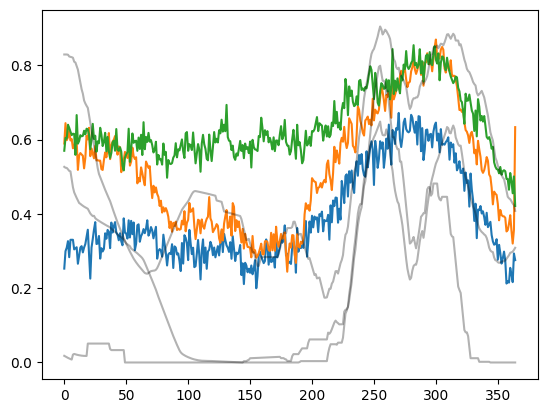

In [31]:
plt.plot(y_pred[50][:, :3])
plt.plot(y_true[50][:, :3], alpha=0.3, color='k')
plt.show()

In [34]:
batch_x, batch_y, batch_x_mark, batch_y_mark = inputs[0]
y_pred, y_true = test_prediction(batch_x, batch_y, batch_x_mark, batch_y_mark)

print(y_pred.shape)
print(y_true.shape)

(64, 365, 8)
(64, 365, 8)


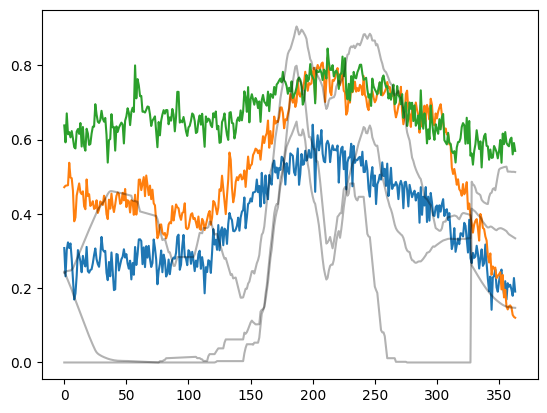

In [36]:
plt.plot(y_pred[10][:-1, :3])
plt.plot(y_true[10][:-1, :3], alpha=0.3, color='k')
plt.show()

In [37]:
batch_x, batch_y, batch_x_mark, batch_y_mark = inputs[10]
y_pred, y_true = test_prediction(batch_x, batch_y, batch_x_mark, batch_y_mark)

print(y_pred.shape)
print(y_true.shape)

(64, 365, 8)
(64, 365, 8)


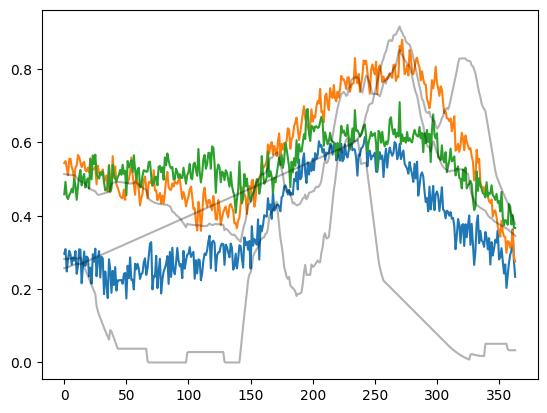

In [39]:
plt.plot(y_pred[50][:-1, :3])
plt.plot(y_true[50][:-1, :3], alpha=0.3, color='k')
plt.show()

In [47]:
batch_x, batch_y, batch_x_mark, batch_y_mark = inputs[4]
y_pred, y_true = test_prediction(batch_x, batch_y, batch_x_mark, batch_y_mark)

print(y_pred.shape)
print(y_true.shape)

(64, 365, 8)
(64, 365, 8)


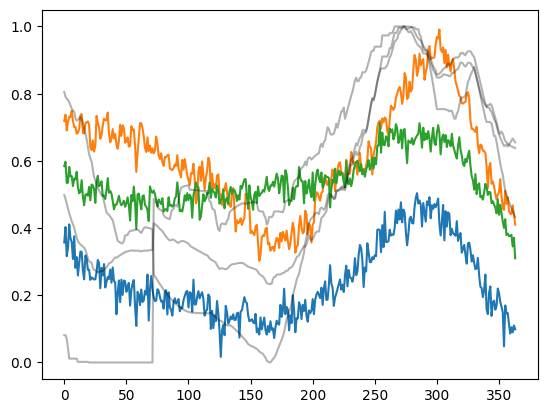

In [48]:
plt.plot(y_pred[10][:-1, :3])
plt.plot(y_true[10][:-1, :3], alpha=0.3, color='k')
plt.show()